<a href="https://colab.research.google.com/github/Ahmad-Jarrar/CS213-Project/blob/master/Recognizer_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and Environment setup

In [1]:
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 81kB 8.2MB/s 


In [2]:
%load_ext tensorboard

In [3]:
import numpy as np
import random
import math
import functools
import os
import PIL
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter as P
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm.notebook import tqdm

from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [4]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

#Model

In [5]:
class BiGRU(nn.Module):
    def __init__(self, total_classes):
        super(BiGRU, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 48, 3, padding=1),
            nn.BatchNorm2d(48),
            nn.LeakyReLU(),
            nn.Conv2d(48, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Dropout2d(0.2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Conv2d(96, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Dropout2d(0.2),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 4),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
        )
        self.gru1 = nn.GRU(256, 256, bidirectional=True)
        self.gru1_bn1 = nn.BatchNorm1d(512)
        self.gru2 = nn.GRU(512, 512, bidirectional=True)
        self.gru2_bn2 = nn.BatchNorm1d(1024)
        self.classifier = nn.Conv1d(1024, total_classes, kernel_size=1)

    def forward(self, x):  # (*, 1, 64, 1300)
        x = self.conv1(x)  # (*, 16, 32, 650)
        x = self.conv2(x)  # (*, 32, 16, 325)
        x = self.conv3(x)  # (*, 64, 8, 325)
        x = self.conv4(x)  # (*, 128, 4, 325)
        x = self.conv5(x)  # (*, 256, 1, 322)
        x = x.squeeze(2)
        x, _ = self.gru1(x.permute(2, 0, 1))  # (322, *, 512)
        x = F.leaky_relu(self.gru1_bn1(x.permute(1, 2, 0)))  # (*, 512, 322)
        x, _ = self.gru2(x.permute(2, 0, 1))  # (322, *, 1024)
        x = F.leaky_relu(self.gru2_bn2(x.permute(1, 2, 0)))  # (*, 1024, 322)
        return F.log_softmax(self.classifier(x), dim=1)  # (*, 1024, 320)

    def get_parameters(self, rnn=True):
        if rnn:
            return self.parameters()
        else:
            parameters = []
            for x in [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5, self.classifier]:
                parameters.extend(list(x.parameters()))
            return parameters


##Model Testing

In [6]:
x = torch.as_tensor(np.random.rand(1,1,64,1500)).float()
recognizer = BiGRU(164)

In [7]:
print(x.size())
y = recognizer(x)
print(y.size())
print(y)

torch.Size([1, 1, 64, 1500])
torch.Size([1, 164, 372])
tensor([[[-4.7718, -4.7763, -5.0676,  ..., -5.4408, -5.1368, -4.9657],
         [-5.6908, -5.4263, -5.2154,  ..., -5.3267, -5.6561, -5.6797],
         [-5.0240, -5.3965, -5.5993,  ..., -5.1978, -5.5041, -5.3951],
         ...,
         [-6.0320, -5.8517, -5.6723,  ..., -6.4237, -6.1844, -5.8232],
         [-5.5601, -5.4270, -4.9811,  ..., -4.6554, -5.1403, -5.3803],
         [-4.5020, -4.9841, -5.4151,  ..., -4.8080, -4.7115, -4.9357]]],
       grad_fn=<LogSoftmaxBackward>)


In [8]:
summary(recognizer, (1,64,1500), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 64, 1500]             160
       BatchNorm2d-2         [-1, 16, 64, 1500]              32
         LeakyReLU-3         [-1, 16, 64, 1500]               0
         MaxPool2d-4          [-1, 16, 32, 750]               0
            Conv2d-5          [-1, 32, 32, 750]           4,640
       BatchNorm2d-6          [-1, 32, 32, 750]              64
         LeakyReLU-7          [-1, 32, 32, 750]               0
         MaxPool2d-8          [-1, 32, 16, 375]               0
            Conv2d-9          [-1, 48, 16, 375]          13,872
      BatchNorm2d-10          [-1, 48, 16, 375]              96
        LeakyReLU-11          [-1, 48, 16, 375]               0
           Conv2d-12          [-1, 64, 16, 375]          27,712
      BatchNorm2d-13          [-1, 64, 16, 375]             128
        LeakyReLU-14          [-1, 64, 

#Data preparation

## Copy dataset from drive and extract (One time job)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from pyunpack import Archive
Archive('/content/drive/My Drive/Datasets/Cleaned_HRT_Dataset.zip').extractall('/content')

In [11]:
# Rename
# Neccessary for the paths in given in files to work
!mv /content/Modified /content/Dataset

##Paths

In [12]:
chars_path = "/content/Dataset/chars.txt"
train_data_path = "/content/Dataset/train.txt"
val_data_path = "/content/Dataset/val.txt"
test_data_path = "/content/Dataset/test.txt"
images_path = "/content/Dataset/images"
root_path = "/content/Dataset"

##Dataset Manipulation Classes

###Character to Index Conversion

In [18]:
class CharacterTransform():
    def __init__(self, path):
        super(CharacterTransform, self)
        self.chars_dict = {}
        self.chars = None
        with open(path, encoding="UTF-8") as f:
            chars = f.read()
            chars = chars.split(sep="\n")
            self.chars = chars
            for i, char in enumerate(chars):
                self.chars_dict[char] = i

    def length(self):
        return len(self.chars)
        
    def labels(self, indices, remove_duplicate_spaces=False):
        
        string = ""
        for i, idx in enumerate(indices):
            if idx == 164:
                continue
            if remove_duplicate_spaces and self.chars[idx] == " " and string[-1] == " ":
                continue
            string += self.chars[idx]
        
        return string[::-1]

    def indices(self, string):
        indices = []

        for i in string:
            indices.append(self.chars_dict[i])

        return indices[::-1]

###Transforms

In [19]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label, label_length = sample['image'], sample['label'], sample["label_length"]

        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label),
                'label_length': torch.from_numpy(label_length)}


class Normalize(object):
    """Normalize"""

    def __call__(self, sample):
        image, label, label_length = sample['image'], sample['label'], sample["label_length"]

        max = np.max(image)
        image = image / (max/2) -1

        return {'image': image,
                'label': label,
                "label_length": label_length}

class TokenizeCharacters(object):
    """String to indices"""

    def __call__(self, sample):
        image, label, label_length = sample['image'], sample['label'], sample["label_length"]

        label = np.array(chars_transform.indices(label))


        return {'image': image,
                'label': label,
                "label_length": np.array([len(label),])}

###Dataset definition

In [20]:
class HRTDataset(Dataset):
    def __init__(self, text_file, root_dir, max_length=1500, img_height=64, padding=False, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.max_length = max_length
        self.img_height = img_height
        self.padding = padding
        
        self.img_paths, self.labels = [], []
        with open(text_file, encoding="UTF-8") as f:
            data = f.read().split("\n")
            data = data[:-1]
            for d in data:
                x,y = d.split("\t")
                self.img_paths.append(x)
                self.labels.append(y)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        pic = PIL.Image.open(self.img_paths[idx])
        img = np.array(pic)

        # Padding to same Width
        if self.padding:
            h, w = img.shape
            frame  = np.ones((self.img_height, self.max_length), dtype=np.uint8) * 255
            f_pad = random.randint(0, self.max_length - w)
            frame[:, f_pad:f_pad+w] = img
            img = frame

        img = img.reshape((1,self.img_height, self.max_length))

        sample = {'image': img, 'label': self.labels[idx], "label_length": [len(self.labels[idx]),]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [21]:
# Pytorch default collate function in Dataloader does not provide ability to work with labels of different lengths
def custom_collate(batch):
    data = [item["image"] for item in batch]
    data = torch.cat(data).float()
    data = torch.unsqueeze(data, 1)
    target = [item["label"] for item in batch]
    target = torch.cat(target)
    length = [item["label_length"] for item in batch]
    length = torch.cat(length)
    return [data, target, length]

###Testing

In [22]:
chars_transform = CharacterTransform(chars_path)

print("No of Characters:", chars_transform.length())

indices = chars_transform.indices("کی ہے کہ جنرل راحیل شریف کو ملک اور پاکستان کے مفاد میں تو")
print("Indices:\n", indices)

string = chars_transform.labels(indices)
print("Labels:\n", string)

No of Characters: 164
Indices:
 [1, 4, 3, 9, 6, 8, 3, 17, 0, 43, 8, 3, 16, 15, 3, 13, 0, 4, 12, 15, 0, 11, 3, 2, 1, 0, 3, 15, 20, 8, 3, 1, 15, 3, 43, 6, 2, 37, 3, 20, 6, 18, 0, 2, 3, 20, 2, 13, 21, 3, 24, 15, 3, 16, 24, 3, 6, 15]
Labels:
 کی ہے کہ جنرل راحیل شریف کو ملک اور پاکستان کے مفاد میں تو


ا
torch.Size([32, 1, 64, 1500])
torch.Size([1708])
torch.int64
tensor([67, 56, 62, 65, 58, 34, 61, 57, 43, 68, 56, 73, 54, 62, 32, 64, 64, 58,
        54, 66, 46, 40, 42, 48, 31, 45, 50, 50, 25, 72, 57, 48])
image shape:  torch.Size([1, 64, 1500])
label shape:  torch.Size([67])
length:  tensor([67])


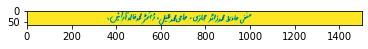

image shape:  torch.Size([1, 64, 1500])
label shape:  torch.Size([56])
length:  tensor([56])


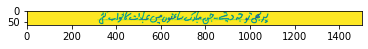

image shape:  torch.Size([1, 64, 1500])
label shape:  torch.Size([62])
length:  tensor([62])


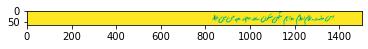

image shape:  torch.Size([1, 64, 1500])
label shape:  torch.Size([65])
length:  tensor([65])


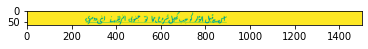

image shape:  torch.Size([1, 64, 1500])
label shape:  torch.Size([58])
length:  tensor([58])


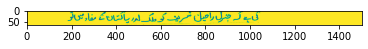

In [24]:
hrt_dataset_test = HRTDataset(text_file=test_data_path, root_dir=root_path, 
                              max_length=1500, img_height=64, padding=True, 
                              transform=torchvision.transforms.Compose([Normalize(),TokenizeCharacters(), ToTensor()]))

test_batches = DataLoader(hrt_dataset_test, batch_size=32, shuffle=False, num_workers=0, collate_fn=custom_collate)

print(chars_transform.labels([0,]))

for batch in test_batches:
    images, labels, lengths = batch

    print(images.shape)
    print(labels.shape)
    print(lengths.dtype)
    print(lengths)
    break
for i in range(5):
    sample = hrt_dataset_test[i]
    shape = sample["image"].shape
    plt.imshow(sample["image"].reshape((shape[1], shape[2])))
    print("image shape: ",sample["image"].shape)
    print("label shape: ",sample["label"].shape)
    print("length: ",sample["label_length"])
    plt.show()

###Test Variables Clean Up

In [25]:
x = None
y = None
recognizer = None
hrt_dataset_test = None
test_batches = None
indices = None
string = None
chars_transform = None

#HyperParameters

In [26]:
chars_transform = CharacterTransform(chars_path)

In [27]:
lr = 0.01
BATCH_SIZE = 64
MAX_LENGTH = 1500
IMG_HEIGHT = 64
INPUT_DIM = (1, IMG_HEIGHT, MAX_LENGTH)
OUTPUT_CLASSES =chars_transform.length() + 1
FILTER_MULTIPLIER = 32
# BLANK = chars_transform.indices(" ")[0]
BLANK = 164
SEQ_LENGTH = 372

In [28]:
print("Input dim: ",INPUT_DIM)
print("Output Classes: ",OUTPUT_CLASSES)
print("Blank Character: ",BLANK)

Input dim:  (1, 64, 1500)
Output Classes:  165
Blank Character:  164


In [29]:
transforms = transforms.Compose([Normalize(),TokenizeCharacters(), ToTensor()])

#Dataset Loading and Batch Creation

In [30]:
hrt_dataset_train = HRTDataset(text_file=train_data_path, 
                               root_dir=root_path, 
                               max_length=MAX_LENGTH, 
                               img_height=IMG_HEIGHT, 
                               padding=True, transform=transforms)
hrt_dataset_val = HRTDataset(text_file=val_data_path, 
                             root_dir=root_path, 
                             max_length=MAX_LENGTH, 
                             img_height=IMG_HEIGHT, 
                             padding=True, transform=transforms)
hrt_dataset_test = HRTDataset(text_file=test_data_path, 
                              root_dir=root_path, 
                              max_length=MAX_LENGTH, 
                              img_height=IMG_HEIGHT, 
                              padding=True, transform=transforms)

In [31]:
train_batches = DataLoader(hrt_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=custom_collate, drop_last=True)
val_batches = DataLoader(hrt_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=custom_collate, drop_last=True)
test_batches = DataLoader(hrt_dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=custom_collate, drop_last=True)

#Training Setup

In [32]:
model = BiGRU(OUTPUT_CLASSES).cuda()
summary(model, INPUT_DIM, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 16, 64, 1500]             160
       BatchNorm2d-2         [64, 16, 64, 1500]              32
         LeakyReLU-3         [64, 16, 64, 1500]               0
         MaxPool2d-4          [64, 16, 32, 750]               0
            Conv2d-5          [64, 32, 32, 750]           4,640
       BatchNorm2d-6          [64, 32, 32, 750]              64
         LeakyReLU-7          [64, 32, 32, 750]               0
         MaxPool2d-8          [64, 32, 16, 375]               0
            Conv2d-9          [64, 48, 16, 375]          13,872
      BatchNorm2d-10          [64, 48, 16, 375]              96
        LeakyReLU-11          [64, 48, 16, 375]               0
           Conv2d-12          [64, 64, 16, 375]          27,712
      BatchNorm2d-13          [64, 64, 16, 375]             128
        LeakyReLU-14          [64, 64, 

In [33]:
ctc_loss = nn.CTCLoss(blank=BLANK, reduction="sum").cuda()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

output_lengths = input_lengths = torch.full(size=(BATCH_SIZE,), fill_value=SEQ_LENGTH, dtype=torch.int64)

train_loss_history = []
val_loss_history = []

#Training

In [34]:
def train_step(batch):
    optimizer.zero_grad()
    images, labels, label_lengths = batch
    pred_y = model(images.cuda())
    # pred_y = F.log_softmax(pred_y, -1)
    pred_y = pred_y.permute(2,0,1)
    loss = ctc_loss(pred_y, labels, output_lengths, label_lengths)
    loss.backward() 
    optimizer.step()
    return loss.detach().item()

def val_step(batch):
    with torch.no_grad():
        images, labels, label_lengths = batch
        pred_y = model(images.cuda())
        # pred_y = F.log_softmax(pred_y, -1)
        pred_y = pred_y.permute(2,0,1)
        loss = ctc_loss(pred_y, labels, output_lengths, label_lengths)
        return loss.detach().item()

In [35]:
epochs= 20
for i in range(epochs):
    loss_acummulator = 0
    
    print("Training:")
    model.train()
    for batch in tqdm(train_batches):
        loss = train_step(batch)
        train_loss_history.append(loss)
        loss_acummulator += loss

    print("Validation:")
    model.eval()
    val_loss_acculmulator = 0
    for batch in tqdm(val_batches):
        loss = val_step(batch)
        val_loss_history.append(loss)
        val_loss_acculmulator += loss


    print("Epoch: {}\tLoss: {}\tValidation Loss: {}".format(i+1, loss_acummulator, val_loss_acculmulator))

Training:



Validation:



Epoch: 1	Loss: 1775179.7587890625	Validation Loss: 167675.908203125
Training:



Validation:



Epoch: 2	Loss: 1375870.537109375	Validation Loss: 165665.2265625
Training:



Validation:



Epoch: 3	Loss: 1354238.1552734375	Validation Loss: 168859.580078125
Training:



Validation:



Epoch: 4	Loss: 1333677.5419921875	Validation Loss: 160900.193359375
Training:



Validation:



Epoch: 5	Loss: 1316696.9814453125	Validation Loss: 160782.01171875
Training:



Validation:



Epoch: 6	Loss: 1189437.4560546875	Validation Loss: 122570.58984375
Training:



Validation:



Epoch: 7	Loss: 649279.8977050781	Validation Loss: 60050.07177734375
Training:



Validation:



Epoch: 8	Loss: 413258.0378417969	Validation Loss: 47013.68115234375
Training:



Validation:



Epoch: 9	Loss: 332621.14123535156	Validation Loss: 39343.07421875
Training:



Validation:



Epoch: 10	Loss: 288466.3610839844	Validation Loss: 33832.183837890625
Training:



Validation:



Epoch: 11	Loss: 257777.1951904297	Validation Loss: 32407.3154296875
Training:



Validation:



Epoch: 12	Loss: 233927.98278808594	Validation Loss: 29960.713500976562
Training:



Validation:



Epoch: 13	Loss: 216648.17260742188	Validation Loss: 29501.022827148438
Training:



Validation:



Epoch: 14	Loss: 200756.544921875	Validation Loss: 28202.125854492188
Training:



Validation:



Epoch: 15	Loss: 187636.46447753906	Validation Loss: 27095.759765625
Training:



Validation:



Epoch: 16	Loss: 176072.3120727539	Validation Loss: 27135.212280273438
Training:



Validation:



Epoch: 17	Loss: 165151.63006591797	Validation Loss: 26803.238037109375
Training:



Validation:



Epoch: 18	Loss: 155323.66162109375	Validation Loss: 26375.11083984375
Training:



Validation:



Epoch: 19	Loss: 145826.66046142578	Validation Loss: 26206.556030273438
Training:



Validation:



Epoch: 20	Loss: 136428.6312866211	Validation Loss: 27046.942504882812


In [36]:
!nvidia-smi

Fri Mar 26 08:03:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   6744MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Testing

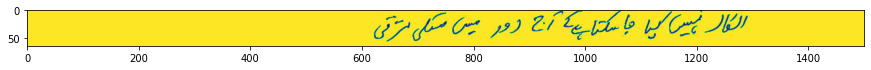

model output:  الکار نہہییں ککییا جااسسککتتتتااےکے آجے دور مییںں ملکی مرقیی


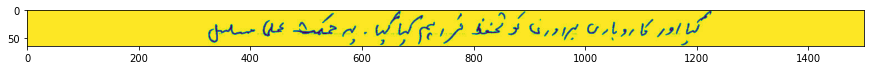

model output:  گگییاا ااورر کاروبار برادری کو تحفظ فرراہہمم ککیاا گگییاا۔ یہ حمکممتت عملی مسلسل


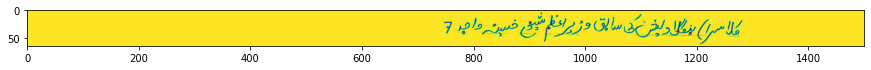

model output:  کلااسررا) ببننگگلااا دییش کیی ساابق وزیر اعظم شخ خسسینہ وااجد7


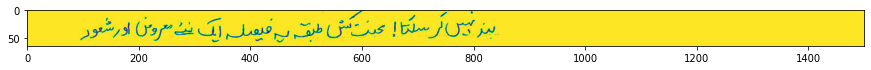

model output:  بنند نہہیںں کررسسکتا!محتت ککش طببقہ یہ فیصللہہ ایک نئے معرروض ااور ششعور


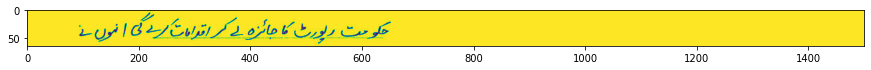

model output:  حککوومتت رپورٹ کاا جائززہ للے کر اقدامات ککررے گی اانہووںں ننےے


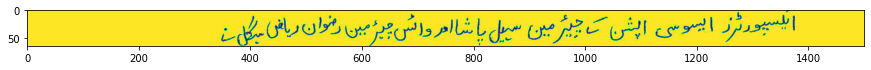

model output:  اییکسسپپورٹرز اییسسووسیی اایشنن کےے چیییئئر میینن سہییلل پااششاا ااور وائسس چییئئرمین رضوواان ریااض سگگل نےے


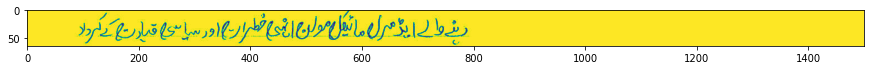

model output:  دہنے والےے ایڈڈمرل مائیکل مولج اانہیی خطراان اور سسییاسسی قییااد کےے کردرر


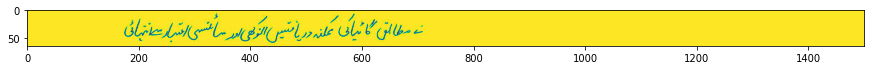

model output:  نےے ممططاابقق گاائیاکی مککننہہ دریااتییںں اانووکھیی اوور ساائئننسسیی اتتباار سے انتہہاائیی


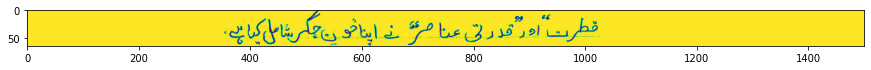

model output:  خطرتت‘‘ اور ’’قددرتیی عننااصر‘‘ نےے اپناا خوون جگگرر ششامل کیااہےے۔۔


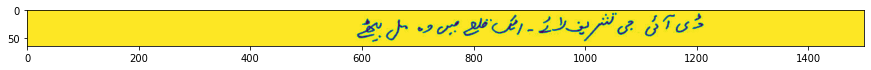

model output:  ڈیی آٓئیی جیی تششریفف لائے۔ ائک قللعےے مییں وہ ملل بیٹٹھھےے


In [41]:
model.eval()
for i in range(10):
    sample = hrt_dataset_train[i]
    shape = sample["image"].shape
    plt.figure(figsize=(15,15))
    plt.imshow(sample["image"].reshape((shape[1], shape[2])))
    plt.show()
    # print("image shape: ",sample["image"].shape)
    # print("label shape: ",sample["label"].shape)
    # print("length: ",sample["label_length"])
    out = model(torch.unsqueeze(sample["image"], 0).float().cuda())
    out = out.cpu().squeeze(0).permute(1,0).detach().numpy()
    out = np.argmax(out, axis=-1).astype(np.uint8).tolist()
    print("model output: ", chars_transform.labels(out, remove_duplicate_spaces=True))

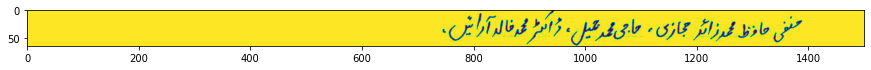

model output:  منفیی ماافظظ ممحمدزاائد مجماازیی، حاجیی محمد ممیلل،، ڈاکٹرر ممحمدد فاالد آرائییںں،


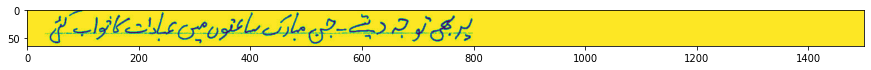

model output:  پر بھھیی توجہہ دیتے۔۔جن مباارکک سسااعتووں مییںں عبااداات کا خوواب کئیی


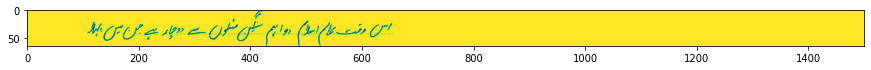

model output:  اسس وقتت عام ااسلامم دوااہم سگگن سنلووں سسےے دوچار ہہےے جنن ممیںں ببہدد


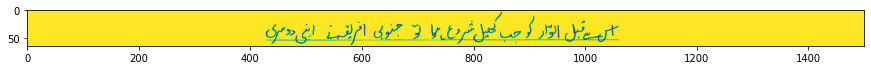

model output:  اس سے قیل اتوواار کو جبب کھھییل ششروع ہہوا تو جننووبییی افریقہ نےےے اپننیی دوسریی


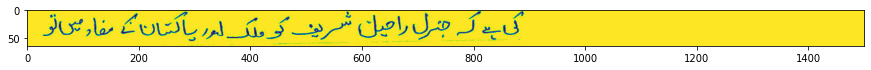

model output:  کیی ہےے کہہ جنرل رااحیی ششرریف کو ملک اور پااکسستتاانن کککےے مفااد مییں توو


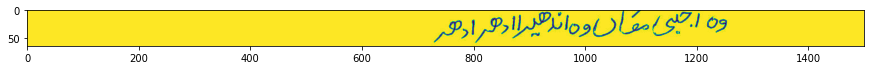

model output:  وہ اجییی مھاا وہ اند میرا ادھھھر ادھھھر


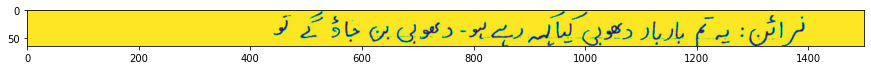

model output:  نرائن: یہ تم بارباار دھھھووبیی کییاا ککہ رہہےے ہوو۔ دھھھووبی بنن جااؤ گےے توو


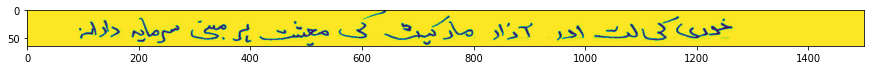

model output:  خوودی کیی لتت اور آزار ماارکیٹ ککیی مععشتت ہر مییے سسرماایہ ارانہ


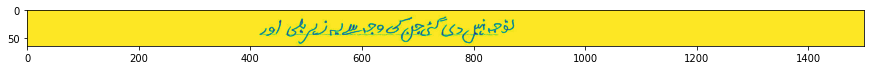

model output:  توجہہ نہییں دی گگئئی جنن کی وجہ سسے یہہ زہرہلیی اوور


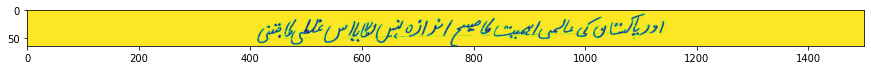

model output:  اور پپااککسستتتاانن کی عاالممیی اہممیتت کاصیسح اندازہ ننہییں لگاایااااس عمللطی کاجتتنیی


In [42]:
model.eval()
for i in range(10):
    sample = hrt_dataset_test[i]
    shape = sample["image"].shape
    plt.figure(figsize=(15,15))
    plt.imshow(sample["image"].reshape((shape[1], shape[2])))
    plt.show()
    # print("image shape: ",sample["image"].shape)
    # print("label shape: ",sample["label"].shape)
    # print("length: ",sample["label_length"])
    out = model(torch.unsqueeze(sample["image"], 0).float().cuda())
    out = out.cpu().squeeze(0).permute(1,0).detach().numpy()
    out = np.argmax(out, axis=-1).astype(np.uint8).tolist()
    print("model output: ", chars_transform.labels(out, remove_duplicate_spaces=True))

In [47]:
torch.save({"model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()}, "/content/drive/My Drive/models/HWR-GAN/recognizer-1.pt")


In [48]:
model2 = BiGRU(OUTPUT_CLASSES)
checkpoint = torch.load("/content/drive/My Drive/models/HWR-GAN/recognizer-1.pt")
model2.load_state_dict(checkpoint["model_state_dict"])
model2.cuda()
model2.eval()

BiGRU(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

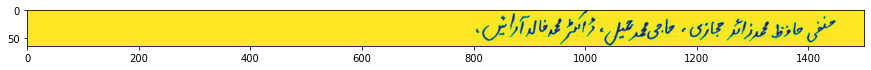

model output:  منفیی ماافظظ ممحمدزاائد مجماازیی، حاجیی محمد میلل،، ڈاکٹرر ممحمدد فاالد آرائییںں،


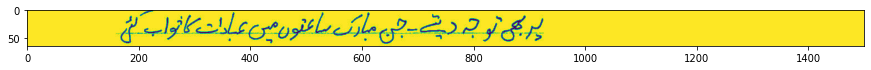

model output:  پر بھھیی توجہ دیتےے۔ جن مباارکک سااعتوں مییںں عبباادات کاا خوابب کئیی


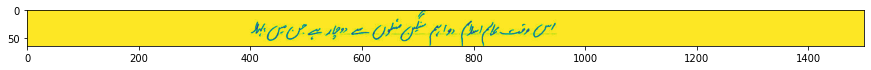

model output:  ااسس وقتت عاامم اسسلامم دواہم سیگگینن سنلووں سے دوچار ہہے جن مییں بہہدد


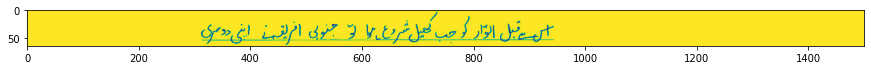

model output:  اس سے قیل اتوواار کو جبب کھھییل ششروع ہہوا تو جننووبییی افریقہ نےےے اپننیی دوسریی


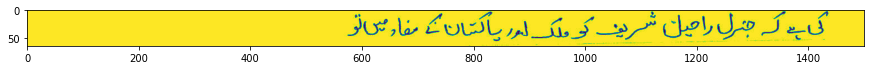

model output:  ککیی ہہےے کہہ جننررل راحی شرریفف کوو ملک اورر پااکسسستتااننن ککےے مفاد میںں تو


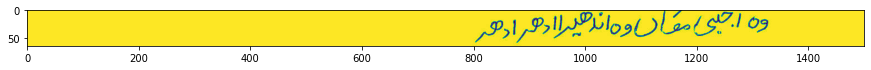

model output:  وہ اجکیی مھاا وہ ااندفییراا ادھھر ادھھر


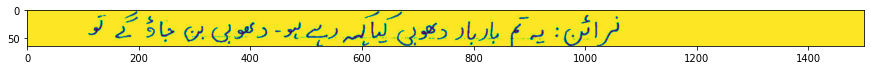

model output:  نرائن: یہ تم بارباار دھھھووبیی کییاا کہ رہہےے ہوو۔ دھھھووبی بنن جااؤ گےے توو


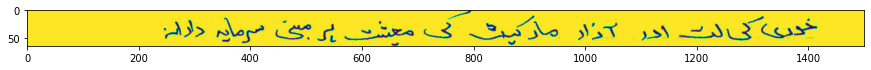

model output:  خوودی کیی لتت اور آزار ماارکیٹ ککیی مععشتت ہرمییے سسرماابہ ارانہ


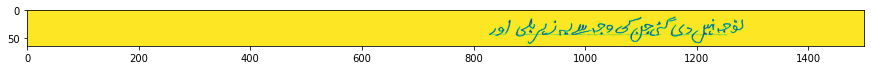

model output:  توجہ نہییںں دی گئی جن کی وجہ سےے ییہہ زہرریلیی اور


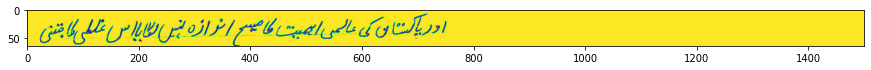

model output:  ااور پااکسستتتاان کی عالمی اہممیت ککااصیح انداازہ ننہہیںں للگاایاااس علطی کاابتنیی


In [49]:
model.eval()
for i in range(10):
    sample = hrt_dataset_test[i]
    shape = sample["image"].shape
    plt.figure(figsize=(15,15))
    plt.imshow(sample["image"].reshape((shape[1], shape[2])))
    plt.show()
    # print("image shape: ",sample["image"].shape)
    # print("label shape: ",sample["label"].shape)
    # print("length: ",sample["label_length"])
    out = model2(torch.unsqueeze(sample["image"], 0).float().cuda())
    out = out.cpu().squeeze(0).permute(1,0).detach().numpy()
    out = np.argmax(out, axis=-1).astype(np.uint8).tolist()
    print("model output: ", chars_transform.labels(out, remove_duplicate_spaces=True))